In [1]:
import math
import json
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedShuffleSplit
from metadata.const import features, dtypes, class_label

In [2]:
config = configparser.RawConfigParser()
config.read('../settings.ini')
data_config = dict(config.items('DATA'))
chunk_size = int(data_config['chunk_size'])

In [3]:
data_files = ['./03-11/LDAP.csv', './03-11/MSSQL.csv', './03-11/NetBIOS.csv', './03-11/Portmap.csv',
              './03-11/Syn.csv', './03-11/UDP.csv', './03-11/UDPLag.csv']

In [4]:
train_df = pd.DataFrame()
for file in data_files:
    chunks = pd.read_csv(
        file,
        chunksize=chunk_size,
        dtype=dtypes,
        parse_dates=[features['timestamp']],
        low_memory=True)
    for df in chunks:
        # devide attack types to benign/ddos
        df['target'] = (df[class_label] != 'BENIGN')
        df['target'].astype(int)
        df.drop(class_label, axis=1, inplace=True)
        df.rename({'target': class_label}, axis=1, inplace=True)
        
        X = df.drop(class_label, axis=True)
        y = df[class_label]
        
        over_sampler = RandomOverSampler(sampling_strategy=0.05)
        X, y = over_sampler.fit_resample(X, y)
        
        under_sampler = RandomUnderSampler(sampling_strategy=1)
        X, y = under_sampler.fit_resample(X, y)
        
        df = pd.concat([X, y], axis=1)
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
        for train_idx, test_idx in split.split(df, df[class_label]):
            train_df = df.iloc[train_idx]
print(len(train_df.index))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

True     50.0
False    50.0
Name:  Label, dtype: float64


<AxesSubplot:>

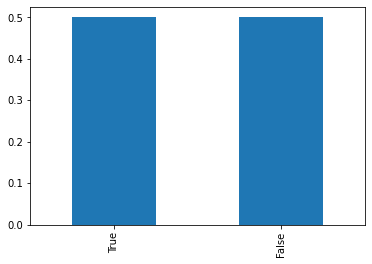

In [6]:
print(train_df[class_label].value_counts(normalize=True) * 100)
train_df[class_label].value_counts(normalize=True).plot(kind='bar')

In [7]:
train_df.to_csv('sample-new.csv', index=False)

In [4]:
label_freq = {}
with open('../metadata/label_frequency.json', 'r') as f:
    label_freq = json.load(f)
print(label_freq)

{'labels': {'LDAP': 1915122, 'NetBIOS': 3657497, 'BENIGN': 56965, 'MSSQL': 5787453, 'Portmap': 186960, 'Syn': 4891500, 'UDP': 3867155, 'UDPLag': 1873}, 'total': 20364525}


In [5]:
sample_config = {}
with open('../metadata/sample_config.json', 'r') as f:
    sample_config = json.load(f)
print(sample_config)

{'labels': {'LDAP': 0.047, 'NetBIOS': 0.089, 'BENIGN': 0.5, 'MSSQL': 0.142, 'Portmap': 0.0045, 'Syn': 0.12, 'UDP': 0.094, 'UDPLag': 4.59868325e-05}, 'total': 200000}


In [8]:
def get_sample(filename, label, label_freq, sample_freq):
    all_df = pd.read_csv(filename, chunksize=chunk_size, dtype=dtypes, parse_dates=[features['timestamp']], low_memory=True)
    final_sample = pd.DataFrame()
    for df in all_df:
        labeled_df = df.loc[df[class_label] == label]
        percent = len(labeled_df.index) / label_freq
        if sample_freq > label_freq:
            sample_df = labeled_df.sample(n=math.ceil(percent * sample_freq), replace=True)
        else:
            sample_df = labeled_df.sample(n=math.ceil(percent * sample_freq))
        final_sample = pd.concat([final_sample, sample_df])
    return final_sample

In [9]:
sample_df = pd.DataFrame()
for l in label_freq['labels'].keys():
    label_df = pd.DataFrame()
    for file in data_files:
        l_sample_freq = sample_config['total'] * sample_config['labels'][l]
        df = get_sample(file, l, label_freq['labels'][l], l_sample_freq)
        label_df = pd.concat([label_df, df])
    sample_df = pd.concat([sample_df, label_df])

In [10]:
print(len(sample_df.index))

199356


In [11]:
sample_df['target'] = (sample_df[class_label] != 'BENIGN')
sample_df['target'].astype(int)
sample_df.drop(class_label, axis=1, inplace=True)
sample_df.rename({'target': class_label}, axis=1, inplace=True)

In [13]:
sample_df.to_csv(f"sample-{sample_config['total']}.csv", index=False)